# Gamma Ray Bursts

In [1]:
import numpy as np
import pylab as plt
import scipy.stats

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
np.random.seed(42)

Read the file

In [3]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')
print(data.shape)

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') 
                     if n.strip()!=''])

(15, 8650)


In [4]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [5]:
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9],dtype=float)
z = np.array(data[11],dtype=float)

## Let's have a look at the data

### T90

First, let's have a look at the time interval containing 90\% of the photon counts and search for modes, if present.

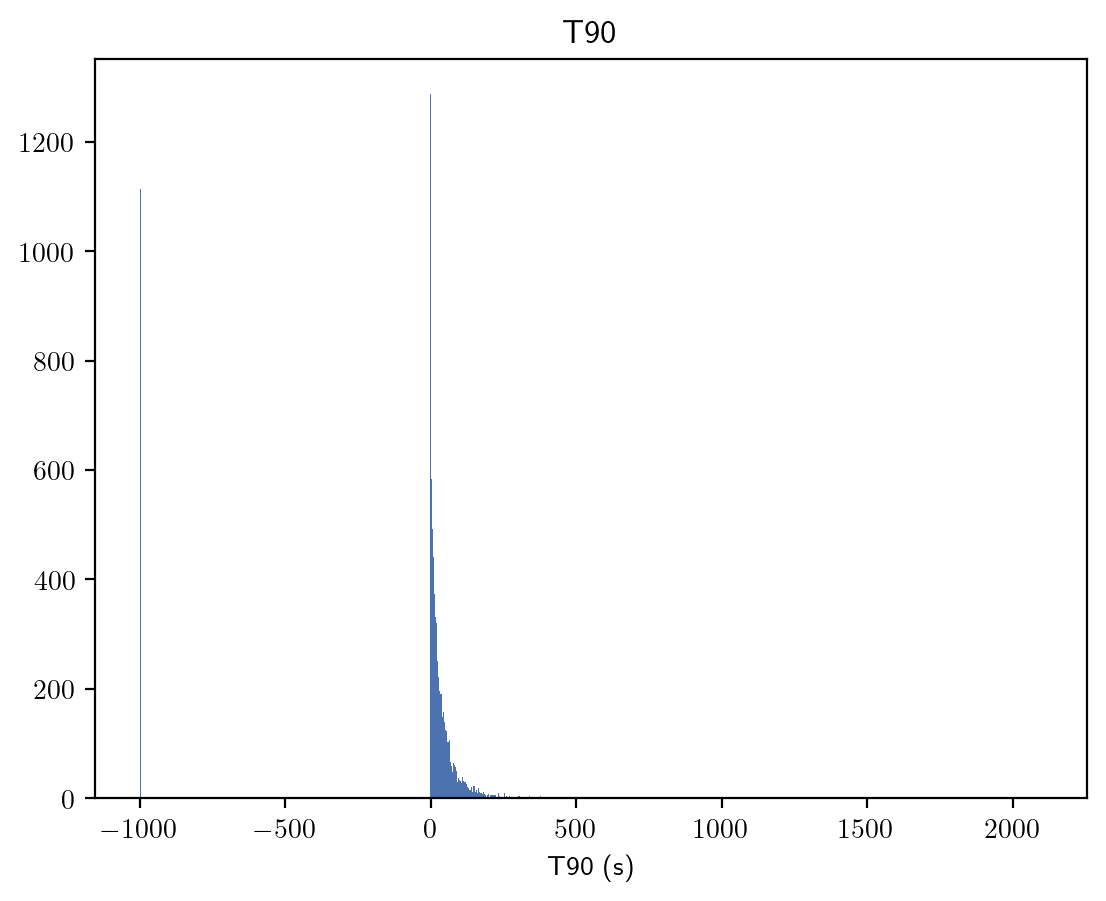

In [6]:
nbins = 1000
plt.hist(T90, bins=nbins, color=None, label=None)
#plt.xlim(-10, 400)
plt.title('T90')
plt.xlabel('T90 (s)')
plt.show()

I already see that there are some outliers. For now, let's focus on the rapresentation of the useful data 
to look for the modes.

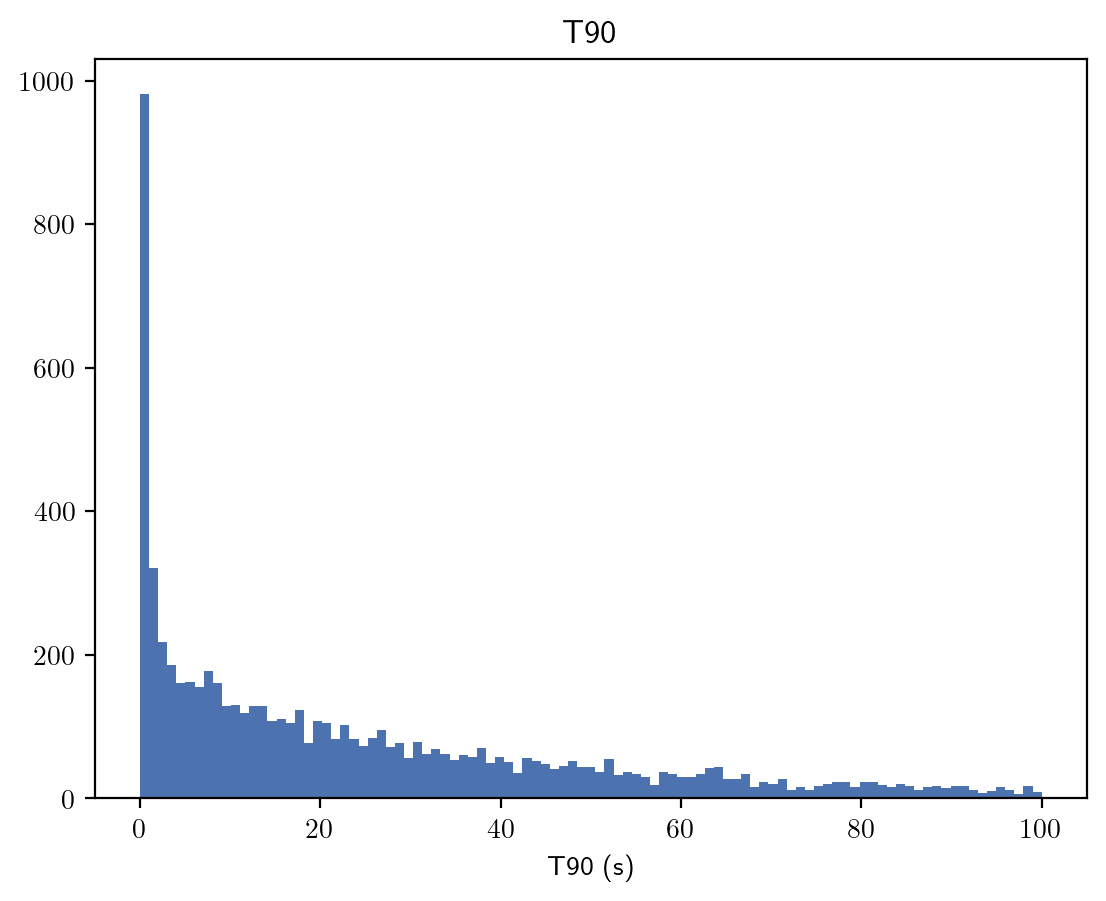

In [7]:
nbins = 100
bins= np.linspace(0,100,nbins)
plt.hist(T90, bins=bins)
plt.title('T90')
plt.xlabel('T90 (s)')
plt.show()

From this representation, I don't see any mode and I notice there's a higher frequency at small T90. Let's try with the log.

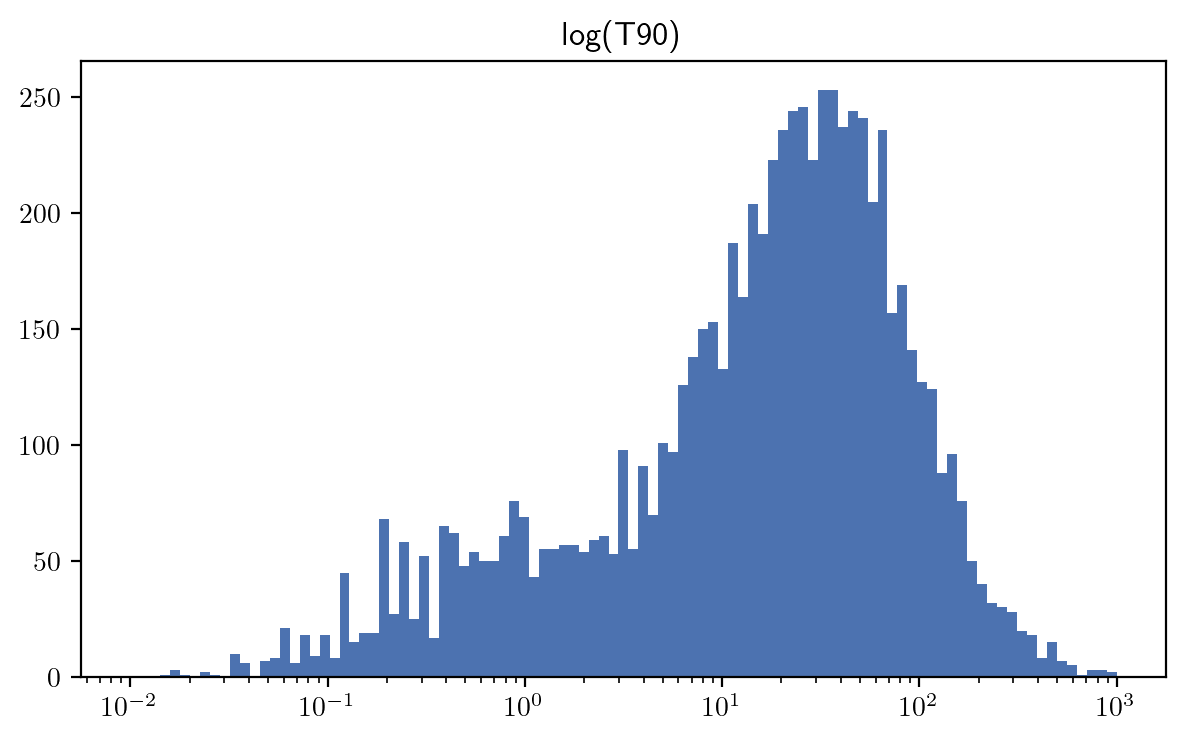

In [8]:
plt.figure(figsize=(7,4))
nbins = 100
plt.hist(T90, bins= np.logspace(-2,3,nbins))
plt.title('log(T90)')
plt.semilogx()
plt.show()

This distribution seems to show a bimodality.

### Fluence

Now, let's look at the time integrated total energy per unit surface --> 'fluence' (erg/cm²).

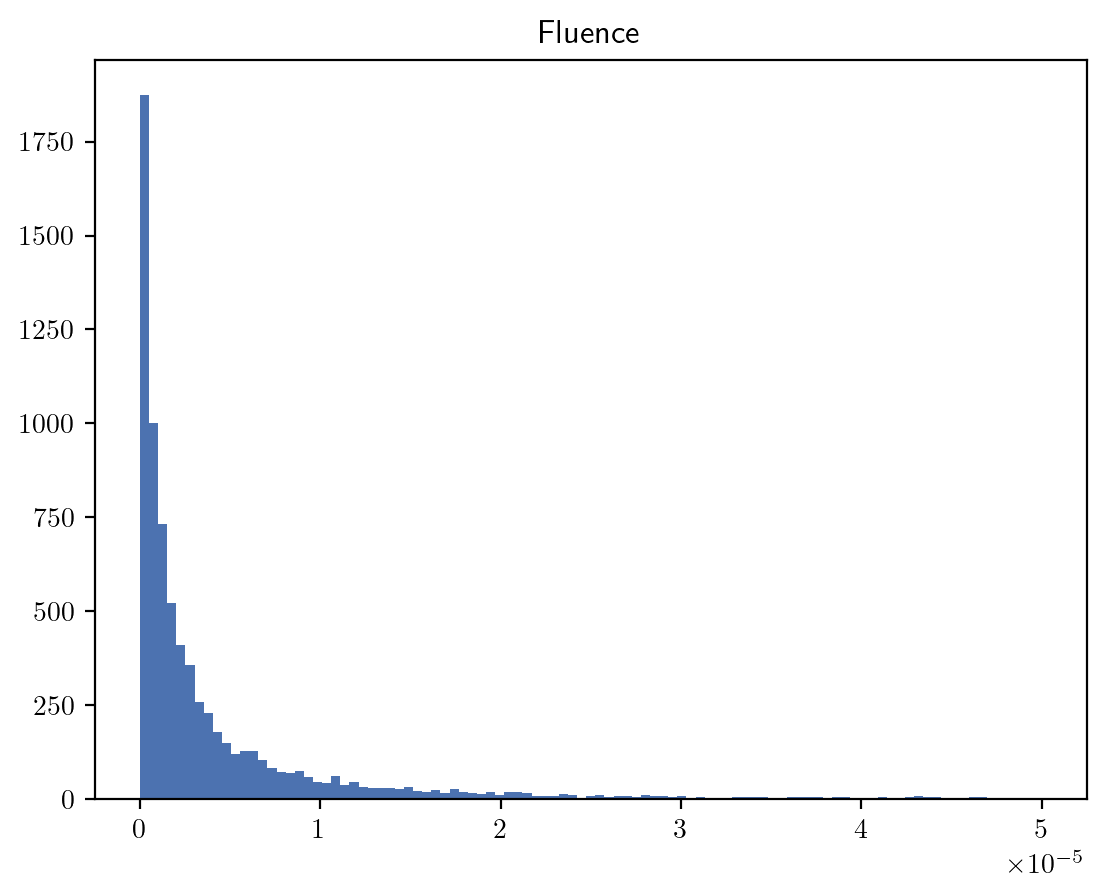

In [9]:
nbins = 100
bins= np.linspace(0,5e-5,nbins)
plt.hist(fluence, bins=bins)
plt.title('Fluence')
plt.show()

Once again, let's move to the log to see if any mode is present.

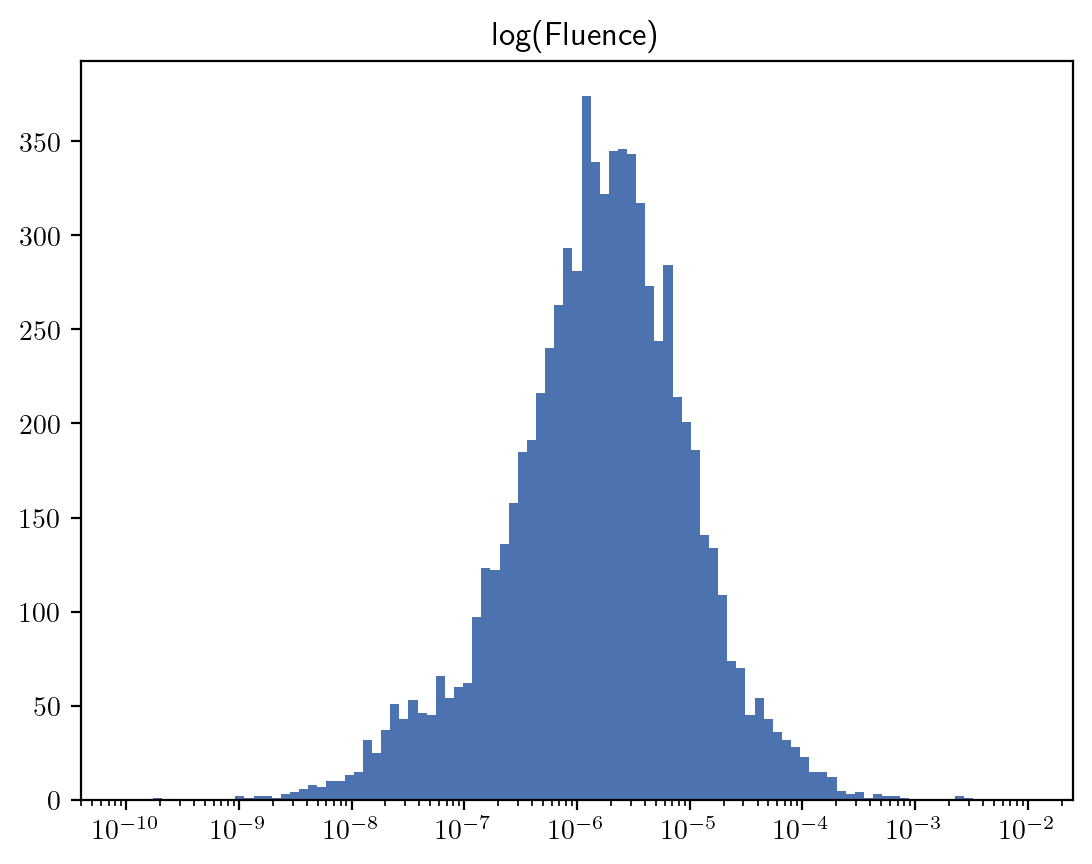

In [10]:
nbins = 100
bins = np.logspace(-10, -2, nbins)
plt.hist(fluence, bins=bins)
plt.title('log(Fluence)')
plt.semilogx()
plt.show()

In this feature, the two modes don't appear to be very distinct, so I probably wouldn't start from here to search for the bimodality.

### Redshift

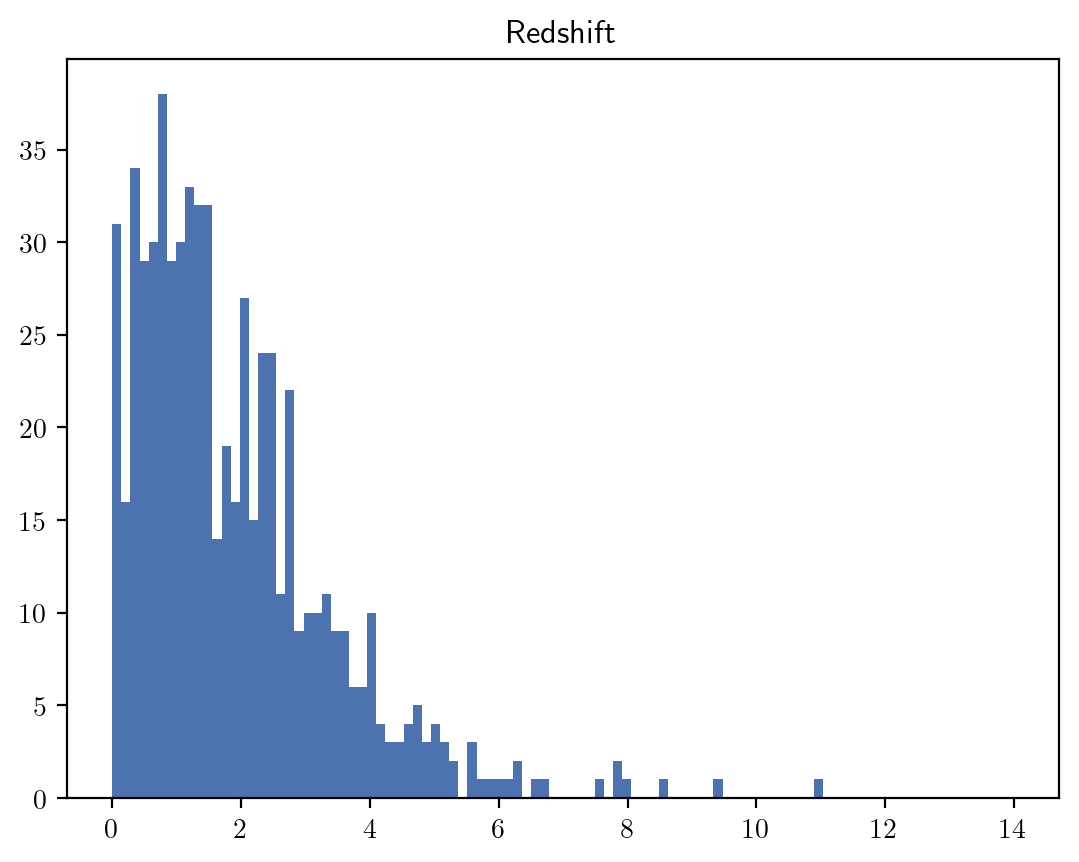

In [11]:
nbins = 100
bins= np.linspace(0,14,nbins)
plt.hist(z, bins=bins)
plt.title('Redshift')
plt.show()

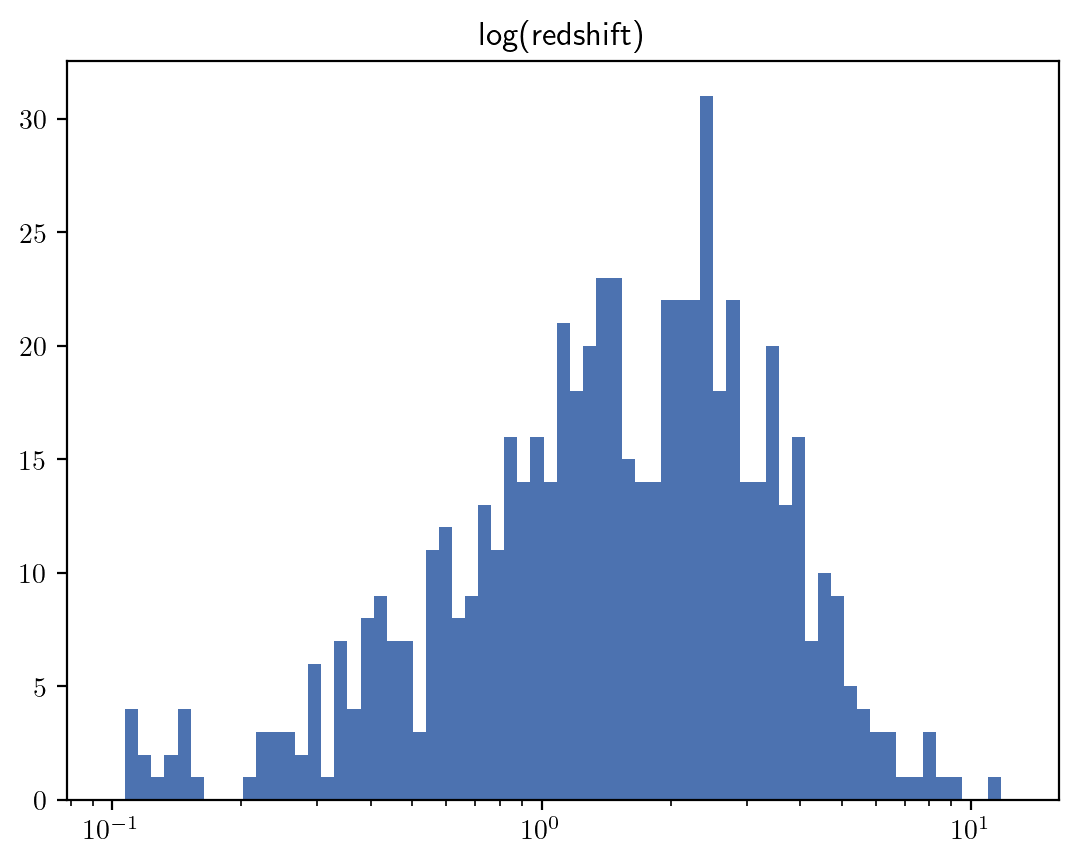

In [12]:
nbins = 70
bins = np.logspace(-1, 1.1, nbins)
plt.hist(z, bins=bins)
plt.title('log(redshift)')
plt.semilogx()
plt.show()

Let's try and see if I can distinguish better the modes fitting a kde.

In [13]:
lz = np.log10(z)

# Let's also clean the data a little bit
lz=lz[~np.isnan(lz)]

lz=lz[:,np.newaxis]

/var/folders/lx/nx_0fbmn2xxcrxcn7tmrlntm0000gn/T/ipykernel_67502/2596853167.py:1: RuntimeWarning: invalid value encountered in log10
  lz = np.log10(z)


In [14]:
h_opt = 0.1 
z_kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(lz)

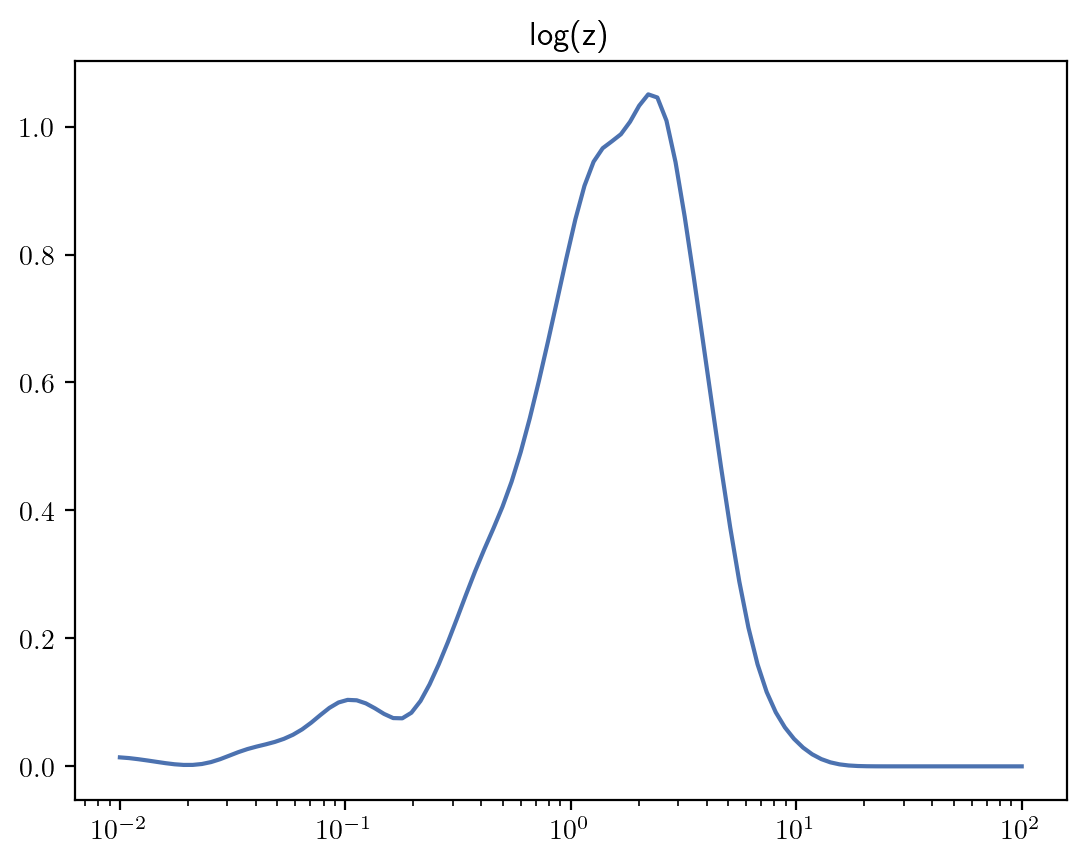

In [15]:
xgrid=np.logspace(-2,2,100)
ygrid = np.exp(z_kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.title('log(z)')
plt.semilogx()
plt.show()

This might contain two modes.

### So, eventually, what should I work on?

For what I could observe from a quick look at the histograms,
it seems that the two modes are easier to distinguish if I work with T90. 
So let's start.

## Fit a KDE

First, let's prepare the data for sklearn

In [16]:
mask = (T90 > 0) & (fluence > 0)

T90 = T90[mask]
fluence = fluence[mask]
z = z[mask]

lT90 = np.log10(T90)
lfluence = np.log10(fluence)

# Clean the data by removing NaN values for all three variables
mask = ~np.isnan(lT90) & ~np.isnan(lfluence) & ~np.isnan(z)

lT90 = lT90[mask][:, np.newaxis]
lfluence = lfluence[mask][:, np.newaxis]
z = z[mask]

Search for the optimized bandwith

Plot the KDE

In [17]:
h_opt = 0.1  # found in the cell above (it can be rerun if needed)
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt).fit(lT90)

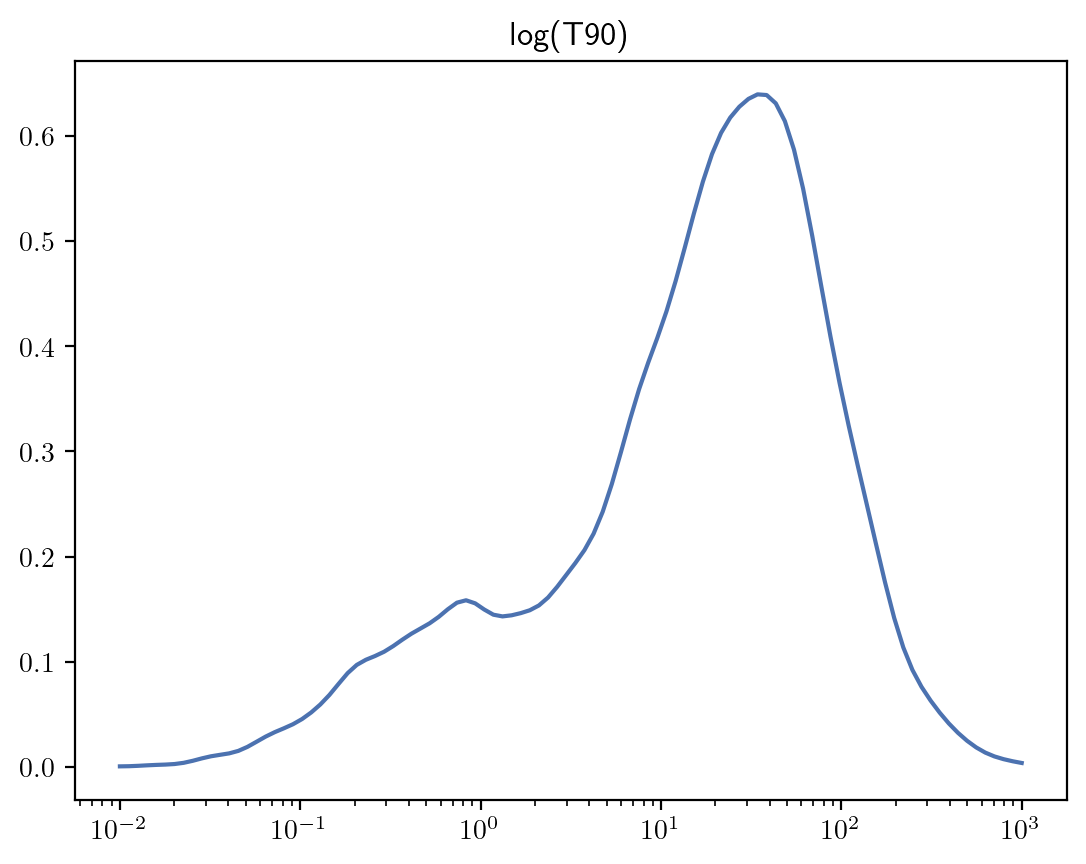

In [18]:
xgrid=np.logspace(-2,3,100)
ygrid = np.exp(kde.score_samples(np.log10(xgrid)[:,np.newaxis]))

plt.plot(xgrid,ygrid)
plt.title('log(T90)')
plt.semilogx()
plt.show()

Here I can see the two modes more clearly.

## Clustering: Kmeans with 2 clusters

In [19]:
X = lT90

clf = KMeans(n_clusters=2, n_init='auto')
clf.fit(X)

centers = clf.cluster_centers_ #location of the clusters
labels_k = clf.predict(X) #labels for each point
inertia = clf.inertia_ #Sum of squared distances of samples to their closest cluster center

print('Sum of squared distances of samples to their closest cluster center (weighted): ' + str(inertia))
print('')
print('Number of points in cluster 0: ' + str(np.count_nonzero(labels_k == 0)))
print('Number of points in cluster 1: ' + str(np.count_nonzero(labels_k == 1)))
print('')
print('Centers (in log):')
print(centers)

Sum of squared distances of samples to their closest cluster center (weighted): 1538.9176231853976

Number of points in cluster 0: 5528
Number of points in cluster 1: 1890

Centers (in log):
[[ 1.52044902]
 [-0.0370881 ]]


I make sure the clusters are ordered correctly

In [20]:
if centers[0] > centers[1]:
    centers = centers[::-1]        # Reverse array
    labels_k = 1 - np.array(labels_k)  # Swap 0 <--> 1

#print(centers)

Find the edge

In [21]:
edge = np.mean( [ max(lT90[labels_k==0]), min(lT90[labels_k==1]) ])
print('Edge (in log): ' +str(edge))

Edge (in log): 0.7413087514783269


Now let's check where the two centers and the edge are positioned

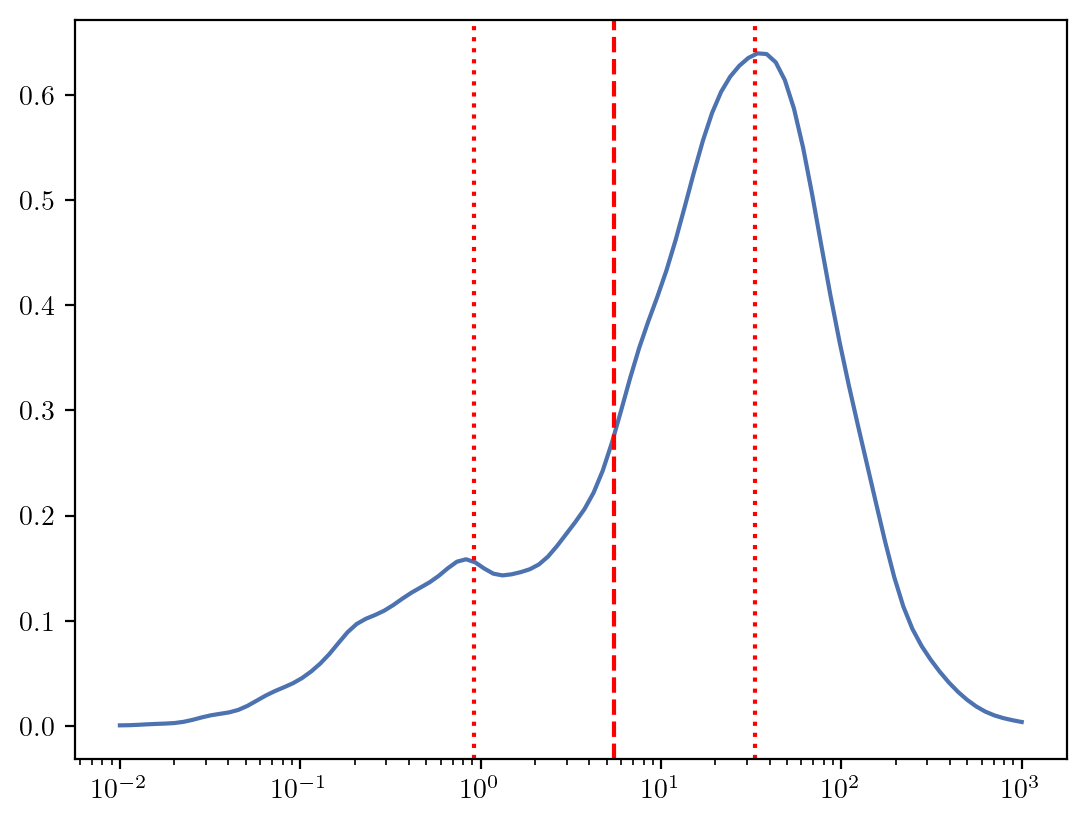

In [22]:
centers_plot = 10**centers
edge_plot = 10**edge

plt.plot(xgrid,ygrid)
plt.semilogx()

for v in centers_plot:
    plt.axvline(v, c='red',ls='dotted')
    
plt.axvline(edge_plot, c='red', ls='dashed')

plt.show()

They truly seem like gaussian, so I can try to fit it also with GaussianMixture.

## Clustering: Gaussian Mixture model

In [23]:
gm = GaussianMixture(n_components=2)
gm.fit(X)

GaussianMixture(n_components=2)

Make sure the clusters are ordered correctly.

In [24]:
Xgrid=np.logspace(-3,4,250)
log_Xgrid = np.log10(Xgrid)

means = gm.means_
labels_gauss = gm.predict(X)

#print(means)
#print(labels)

Make sure the gaussians are ordered correctly

In [25]:
if means[0] > means[1]:
    means = means[::-1]        # Reverse array
    labels_gauss = 1 - np.array(labels_gauss)  # Swap 0 <--> 1

print(means)
print(labels_gauss)

[[-0.01042683]
 [ 1.48717785]]
[0 1 1 ... 0 1 1]


Edge

In [26]:
prob = gm.predict_proba(X)

# Edge defined as the boundary where the probabilities are equal
boundary_index = np.argmin(np.abs(prob[:, 0] - prob[:, 1]))
dec_boundary = X[boundary_index]

print("Decision boundary (log):", dec_boundary)

Decision boundary (log): [0.58793535]


Plot

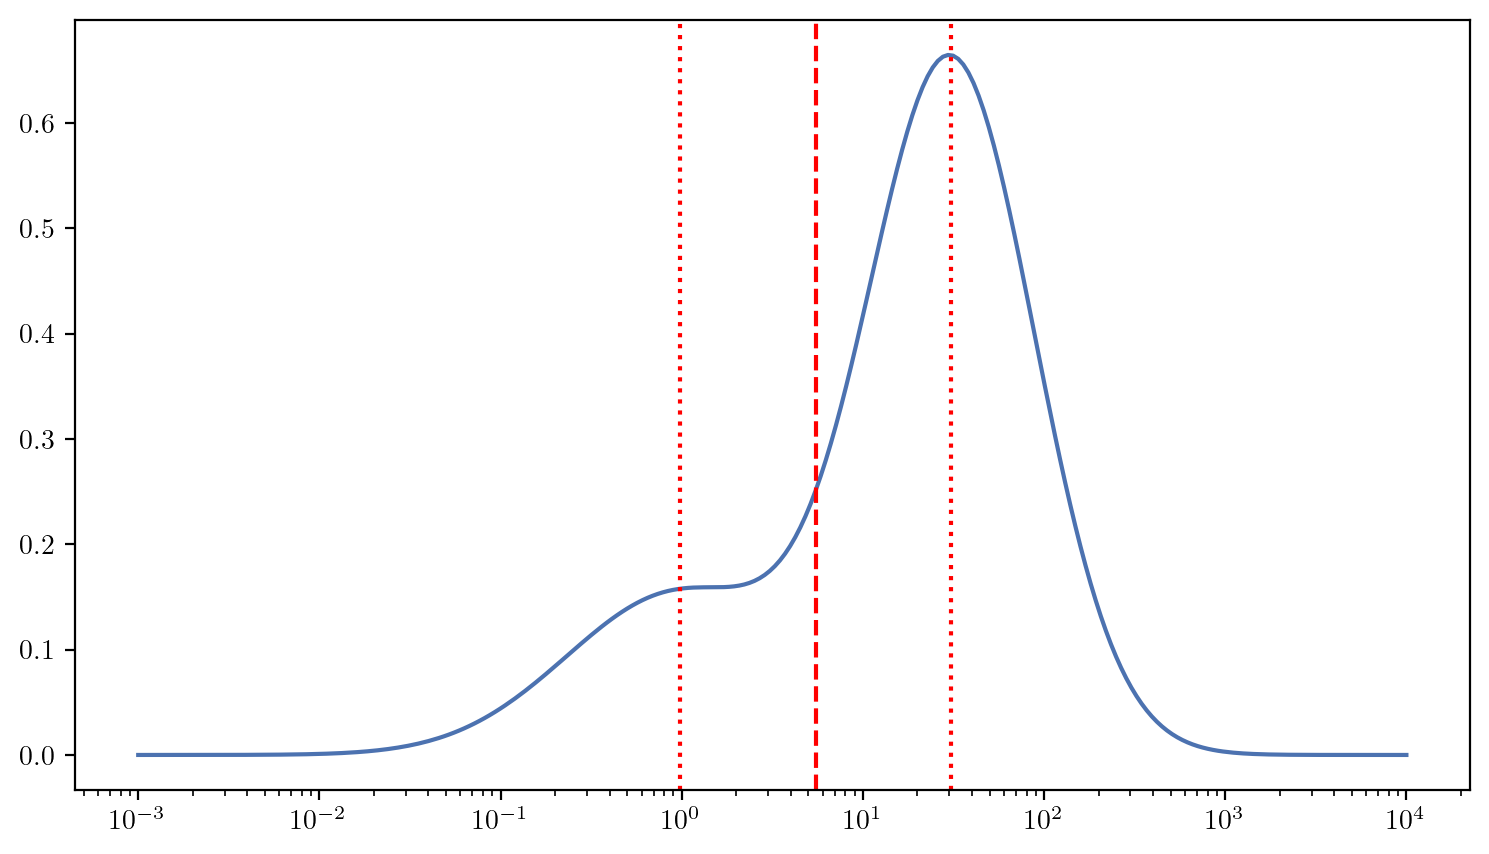

In [27]:
plt.figure(figsize=(9,5))

logprob = gm.score_samples(log_Xgrid[:,np.newaxis])
pdf = np.exp(logprob)

plt.plot(Xgrid, pdf)

means_plot = 10**means
for mean in means_plot:
    plt.axvline(mean, c='red',ls='dotted')

plt.axvline(edge_plot, c='red', ls='dashed')

plt.semilogx()
plt.show()

## Compare the centers in KMeans with the means in GaussianMixture

In [28]:
dist = np.abs((means-centers)/np.mean([means,centers]))

print('Short GRBs (log(T90)):   (c) ' + str(centers[0]) + '   (m) ' + str(means[0]) + '   (dist) ' + str(dist[0]))
print('Long GRBs (log(T90)):    (c) ' + str(centers[1]) + '    (m) ' + str(means[1]) + '      (dist) ' + str(dist[1]))

Short GRBs (log(T90)):   (c) [-0.0370881]   (m) [-0.01042683]   (dist) [0.03602739]
Long GRBs (log(T90)):    (c) [1.52044902]    (m) [1.48717785]      (dist) [0.04495934]


Convert back the log

In [29]:
print('Short GRBs (log(T90)):   (c) ' + str(10**(centers[0])) + '    (m) ' + str(10**(means[0])) + '    (dist) ' + str(10**(dist[0])))
print('Long GRBs (log(T90)):    (c) ' + str(10**(centers[1])) + '    (m) ' + str(10**(means[1])) + '   (dist) ' + str(10**(dist[1])))

Short GRBs (log(T90)):   (c) [0.91814632]    (m) [0.97627726]    (dist) [1.08649414]
Long GRBs (log(T90)):    (c) [33.14736601]    (m) [30.70279071]   (dist) [1.10907098]


Compute the confusion matrix, that in this case tells us how many points were classified in the same/different way by the two algorithms.

In [30]:
confusion_matrix(labels_gauss,labels_k)

array([[1617,    0],
       [ 273, 5528]])

Some point that the Gaussian mixture labels as part of the second cluster are assigned to the first by KMeans method.

## Let's have a look at redshift and fluence.

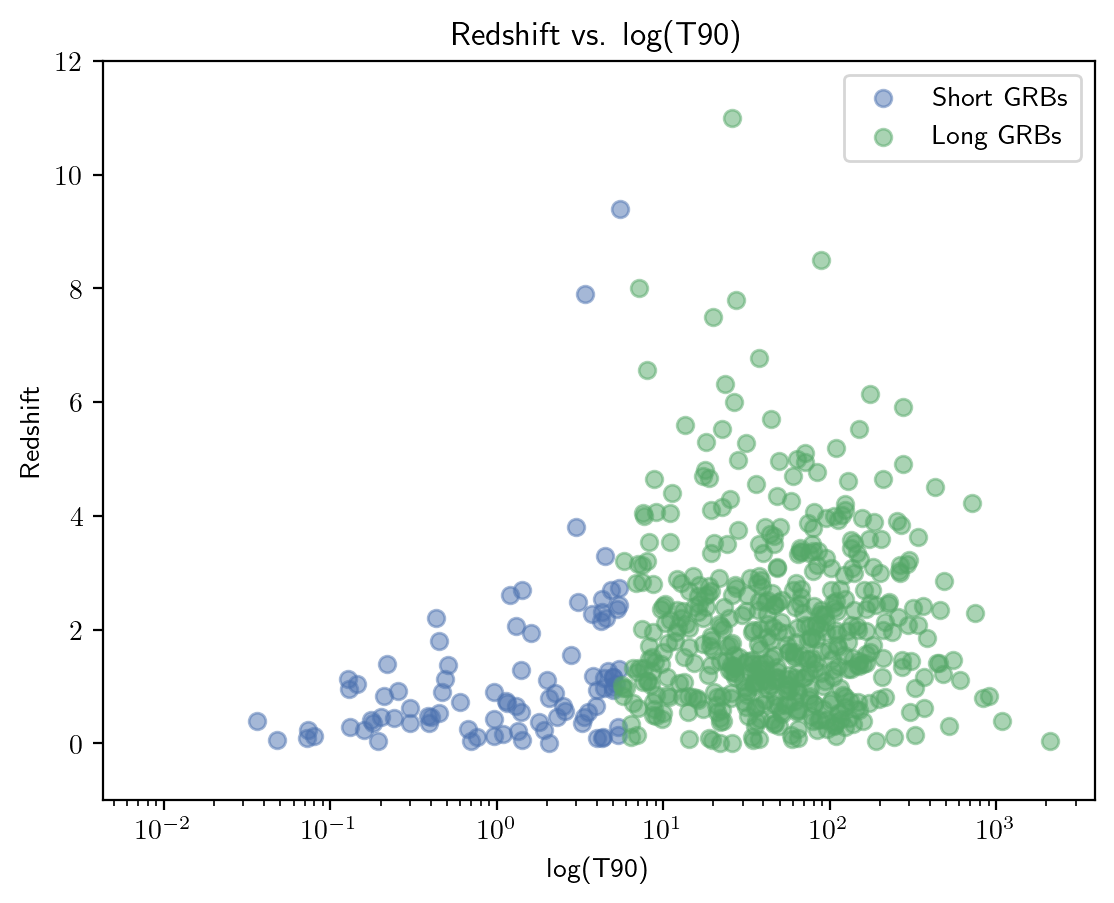

In [31]:
colors = ['C0', 'C1']
labels_graph = ['Short GRBs', 'Long GRBs']
for i in range(2):
    plt.scatter(10**lT90[labels_k==i], z[labels_k==i], 
                color=colors[i],alpha=0.5, label=labels_graph[i])
plt.semilogx()
plt.ylim(-1,12)
plt.title('Redshift vs. log(T90)')
plt.xlabel('log(T90)')
plt.ylabel('Redshift')
plt.legend()
plt.show()

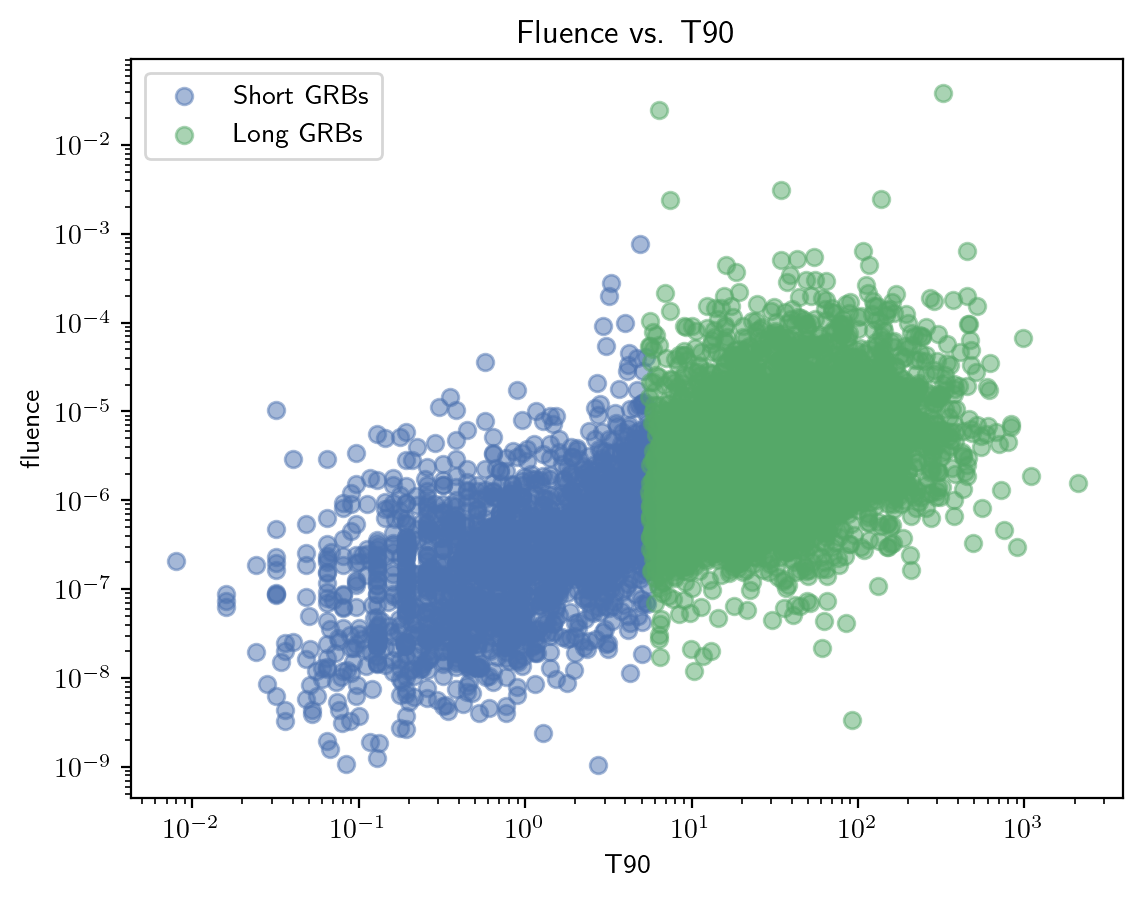

In [32]:
colors = ['C0', 'C1']
labels_graph = ['Short GRBs', 'Long GRBs']

for i in range(2):
    plt.scatter(10**lT90[labels_k==i], 10**lfluence[labels_k==i], 
                color=colors[i],alpha=0.5, label=labels_graph[i])

plt.loglog()
plt.title('Fluence vs. T90')
plt.xlabel('T90')
plt.ylabel('fluence')
plt.legend()
plt.show()

## 2D classification

I could also classify using both fluence and T90.

Number of points in cluster 0: 5375
Number of points in cluster 1: 2043
1.5268897740328768


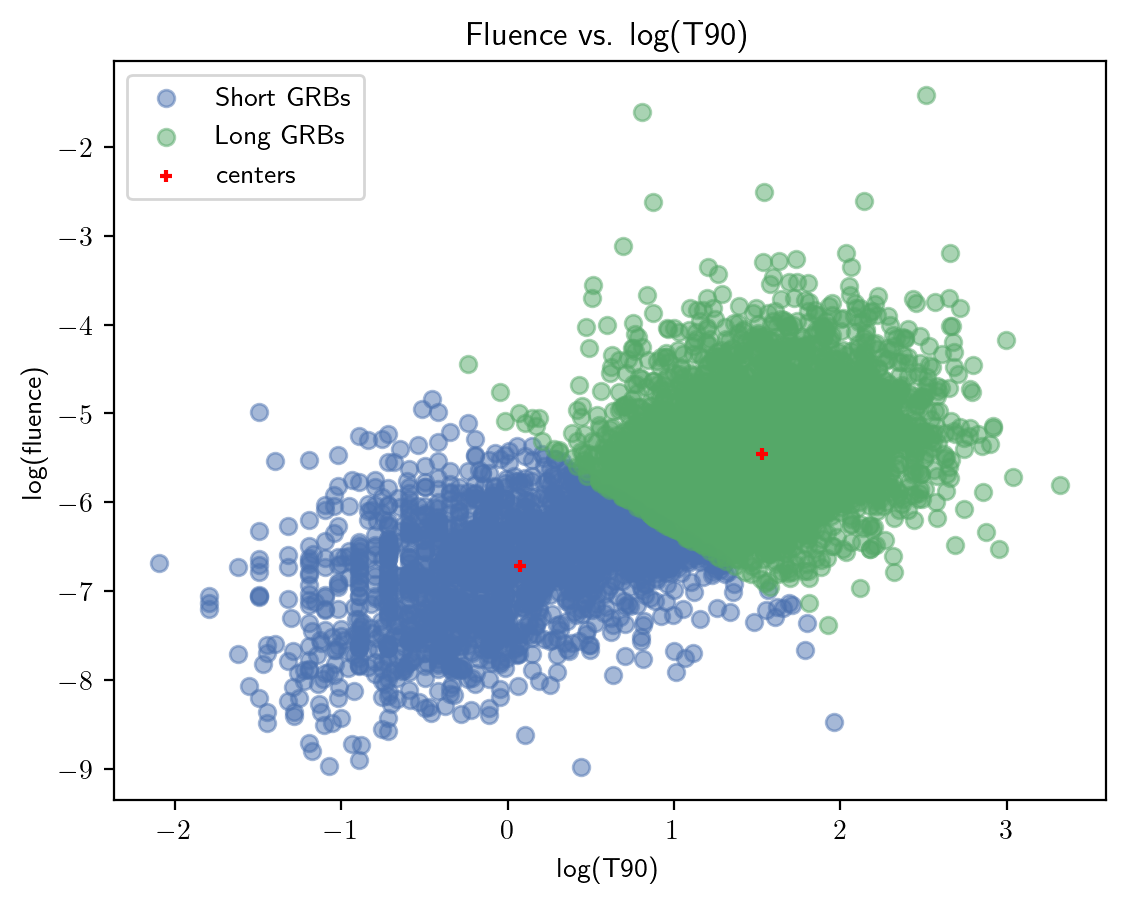

In [33]:
X = np.column_stack((lT90, lfluence))

clf = KMeans(n_clusters=2, n_init='auto')
clf.fit(X)

centers = clf.cluster_centers_ #location of the clusters
labels_2D = clf.predict(X) #labels for each of the points
inertia = clf.inertia_

print('Number of points in cluster 0: ' + str(np.count_nonzero(labels_2D == 0)))
print('Number of points in cluster 1: ' + str(np.count_nonzero(labels_2D == 1)))

print(centers[0,0])
if centers[0,0] > centers[1,0]:
    centers = centers[::-1]        # Reverse array
    labels_2D = 1 - np.array(labels_2D)  # Swap 0 <--> 1

#print(centers)
colors = ['C0', 'C1']
labels_graph = ['Short GRBs', 'Long GRBs']

for ii in range(2):
    plt.scatter(X[labels_2D==ii,0], X[labels_2D==ii,1], 
                color=colors[ii],alpha=0.5, label=labels_graph[ii])

plt.scatter(centers[:,0], centers[:,1], color='red', marker='+', s=20, label='centers')

plt.title('Fluence vs. log(T90)')
plt.xlabel('log(T90)')
plt.ylabel('log(fluence)')
plt.legend()
plt.show()

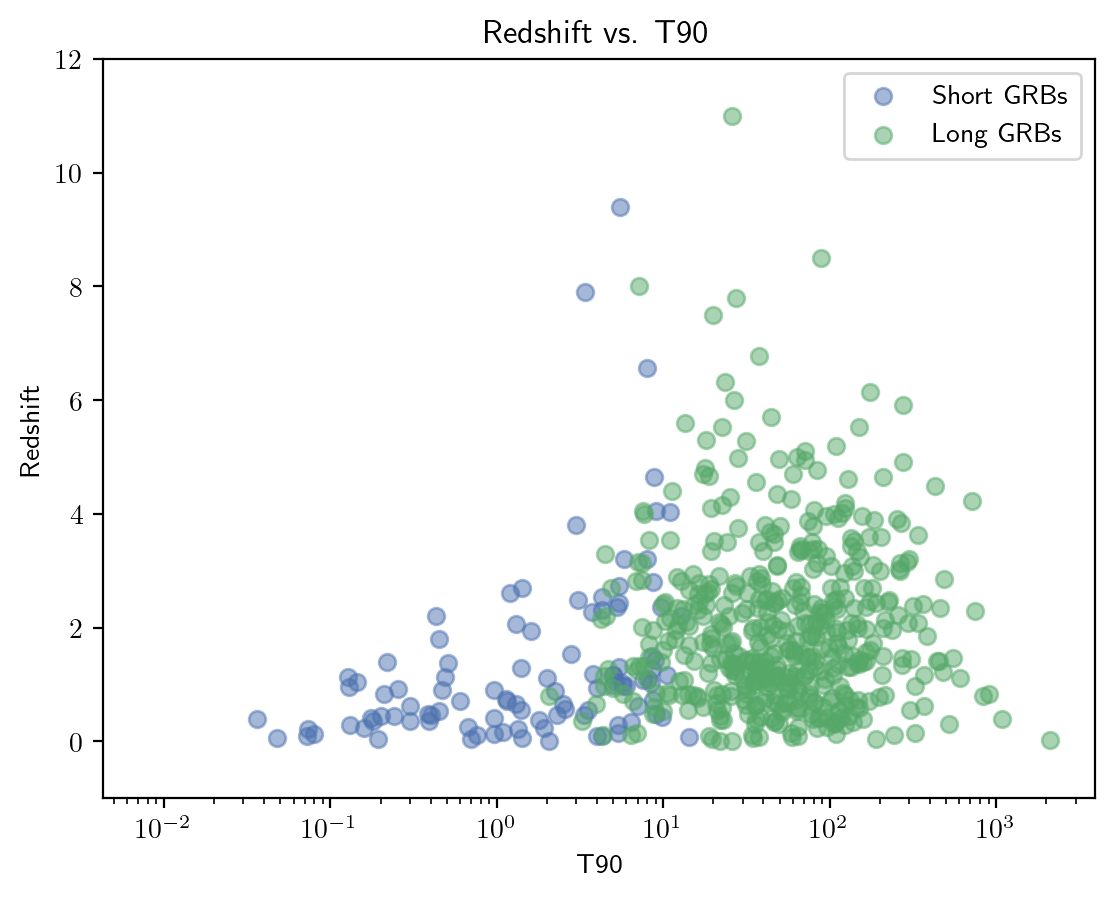

In [34]:
colors = ['C0', 'C1']
labels_graph = ['Short GRBs', 'Long GRBs']
for i in range(2):
    plt.scatter(10**lT90[labels_2D==i], z[labels_2D==i], 
                color=colors[i],alpha=0.5, label=labels_graph[i])
plt.semilogx()
plt.ylim(-1,12)
plt.title('Redshift vs. T90')
plt.xlabel('T90')
plt.ylabel('Redshift')
plt.legend()
plt.show()

In [35]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels_k, labels_2D)
print(f"Confusion matrix for 1D and 2D classification:\n{conf_matrix}")

Confusion matrix for 1D and 2D classification:
[[1734  156]
 [ 309 5219]]
